<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Summary" data-toc-modified-id="Summary-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Summary</a></span><ul class="toc-item"><li><span><a href="#Pre-processing-and-Clean-up" data-toc-modified-id="Pre-processing-and-Clean-up-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Pre-processing and Clean-up</a></span></li><li><span><a href="#Analysing-The-Dataset" data-toc-modified-id="Analysing-The-Dataset-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Analysing The Dataset</a></span></li><li><span><a href="#Limitations" data-toc-modified-id="Limitations-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Limitations</a></span></li></ul></li><li><span><a href="#Dependencies" data-toc-modified-id="Dependencies-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Dependencies</a></span></li><li><span><a href="#Goal" data-toc-modified-id="Goal-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Goal</a></span></li><li><span><a href="#Functions" data-toc-modified-id="Functions-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Functions</a></span></li><li><span><a href="#Tokenise-Email-Bodies" data-toc-modified-id="Tokenise-Email-Bodies-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Tokenise Email Bodies</a></span><ul class="toc-item"><li><span><a href="#Lemmatisation" data-toc-modified-id="Lemmatisation-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Lemmatisation</a></span></li><li><span><a href="#Bigrams" data-toc-modified-id="Bigrams-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Bigrams</a></span></li></ul></li><li><span><a href="#Construct-the-Corpus-and-LDA-model" data-toc-modified-id="Construct-the-Corpus-and-LDA-model-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Construct the Corpus and LDA model</a></span><ul class="toc-item"><li><span><a href="#construct-the-LDA-model" data-toc-modified-id="construct-the-LDA-model-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>construct the LDA model</a></span><ul class="toc-item"><li><span><a href="#Perplexity-and-Coherence" data-toc-modified-id="Perplexity-and-Coherence-6.1.1"><span class="toc-item-num">6.1.1&nbsp;&nbsp;</span>Perplexity and Coherence</a></span></li></ul></li></ul></li><li><span><a href="#Finding-Best-Number-of-Topics" data-toc-modified-id="Finding-Best-Number-of-Topics-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Finding Best Number of Topics</a></span></li><li><span><a href="#Results" data-toc-modified-id="Results-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Results</a></span></li></ul></div>

# Summary
## Pre-processing and Clean-up
The data is initially in a form where each user is a directory.  Within each user's directory there are further directories depending on how they had their emails organised; "sent", "inbox" etc..
I initailly walk through each directory finding the individual emails and saving them as a `string` to a `csv` along side the path to the given file.

After the emails have been pulled, I clean up and linebreak characters that are left behind and save the fields of each email as a new `csv` with the directory still being used as the data point "name".

Before running this notebook, it will be necessary to run either both `Enron_data_extraction.ipynb` and `Enron_email_field_splitting.ipynb` or `data_extraction.py` on an extracted copy of the enron dataset.

## Analysing The Dataset
The dataset consists of over 500000 emails.  There are some fields which are missing for some entries (see `Enron_email_field_splitting.ipynb` for more details), but there are no missing values for the email bodies, which is the main focus of my analysis.  I will conduct unsupervised topic clustering using Latent Dirichlet Allocation (LDA).

I plan to do this by:
1. Splitting each email body into its component words.
2. Removing stop words to reduce the data and amplify the signal.
3. Lemmatise the data i.e. reduce words to their roots/stems e.g. drove --> drive.
4. Constuct bigrams - take words that commonly appear together and treat them as a phrase.
5. Construct the model and maximise coherence (model performance) by changing number of topics.

## Limitations
Given more time and experience there are some aspects of the analysis which I would have liked to improve:
1. Amount of data used to inform the model: Due to computational and time constraints I could not process the whole dataset on my machine.  So as to use the whole dataset for my model, using batch methods would be ideal.  I would also like to speed up the analysis as currently even with more memory analysing the whole dataset would likely take several hours.
2. Currently all single threaded - I would like to multithread the final funciton (`calc_coherence`) to speed up final model comparison.



# Dependencies
`pandas`

`seaborn` 

`spacy`

`python -m spacy download en` - english model from spacy

`gensim`

`pyLDAvis`


In [1]:
# getting deprecation error that likely is fixed with an update but will surpress for now
import warnings
warnings.filterwarnings("ignore", category = DeprecationWarning)

# Goal
To analyse the body of the Enron emails and conduct topic analysis

In [2]:
#progress bars
from tqdm import tqdm

import pickle
from os.path import relpath

# wrangling
import pandas as pd

# lemmatization
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
# import string

# gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.phrases import Phrases, Phraser
from gensim.models.ldamodel import LdaModel
# # plotting
import matplotlib.pyplot as plt
import seaborn as sb
import pyLDAvis.gensim


    
sb.set(style="whitegrid") # to show plots well in darktheme 

Computational limitations have necessitated the need to subset the data.  If I had more time, I would have implemented some form of batch analysis so as to take the whole dataset into the model.

In [3]:
data = pd.read_csv(relpath("../data/email_fields.csv"))["Body"]
print(data.describe())
# data = data.tolist()

# subset
data = data.sample(50000, random_state=1).tolist()

/home/donal/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


count                                                517311
unique                                               247119
top       As you know, Enron Net Works (ENW) and Enron G...
freq                                                    112
Name: Body, dtype: object


# Functions

In [4]:
def sent_to_words(sentences):
    """
    Takes a string and breaks it into words.
    
    Arg:
        sentences (str) : The sentence(s) to be broken down
        
    Returns:
        (list) : words as a list
    """
#     return [simple_preprocess(sentence, deacc=True) for sentence in tqdm(sentences)]
    
    for sentence in tqdm(sentences):
        yield(simple_preprocess(sentence, deacc=True)) # deacc removes punctuation

def remove_stopwords(texts, stop_words):
    """
    Removes the stop words from a piece of text using a specified list of stop words.
    
    Args:
        text (list) : text to have stop words removed from. Should be split by word and given as a list.
        stop_words (set) : stop words for laguage the `text`.
        
    Returns:
        (list) : text list with stop words removed
    """
#     for body in texts:
#         yield([word for word in body if word not in stop_words])
    return [[word for word in body if word not in stop_words] for body in texts]
    
def make_bigrams(words, min_count = 5, threshold = 10):
    """
    Takes a list of words and return bigrams.
    
    Args: taken from `gensim.models.phrases.Phrases` documentation.
        words (iter) :  can be simply a list, but for larger corpora, 
                        consider a generator that streams
                        the sentences directly from disk/network, 
                        See :class:`~gensim.models.word2vec.BrownCorpus`, 
                        :class:`~gensim.models.word2vec.Text8Corpus` 
                        or :class:`~gensim.models.word2vec.LineSentence` for such examples.
        min_count (float), optional : Ignore all words and bigrams with total 
                            collected count lower than this value.
                            Defaults to 5.
        threshold (float), optional : Represent a score threshold for forming the phrases 
                            (higher means fewer phrases). A phrase of words `a` followed 
                            by `b` is accepted if the score of the phrase is greater than threshold.  
                            Heavily depends on concrete scoring-function, see the `scoring` parameter.
    
    Returns :
        (iter) : bigrams
        
    """
    bigrams = Phrases(words)
    return [[bigram for bigram in bigrams[body]] for body in tqdm(words)]
    
def make_trigrams(words):
    """
    Takes a list of words and return bigrams.
    
    Args: taken from `gensim.models.phrases.Phrases` documentation.
        words (iter) :  can be simply a list, but for larger corpora, 
                        consider a generator that streams
                        the sentences directly from disk/network, 
                        See :class:`~gensim.models.word2vec.BrownCorpus`, 
                        :class:`~gensim.models.word2vec.Text8Corpus` 
                        or :class:`~gensim.models.word2vec.LineSentence` for such examples.
        min_count (float), optional : Ignore all words and bigrams with total 
                            collected count lower than this value.
                            Defaults to 5.
        threshold (float), optional : Represent a score threshold for forming the phrases 
                            (higher means fewer phrases). A phrase of words `a` followed 
                            by `b` is accepted if the score of the phrase is greater than threshold.  
                            Heavily depends on concrete scoring-function, see the `scoring` parameter.
    Returns:
        (iter) : trigrams
    """
    return Phrases(make_bigrams(words)[words])
    
    
    
def lemmatisation(text, nlp, allowed_postags = ["NOUN", "ADJ", "VERB", "ADV"]):
    """
    Lemmatises text.  See: 'https://spacy.io/api/annotation' for more info on `allowed_postags`
    
    Args:
        text (str) : texts to be lemmatised.
        nlp : the laguage model of choice.  Defaults to `English` from `spacy`
        allowed_postags (list) : list of parts of speech to be lemmatised.
       
    Returns:
        (list)
    """
    text_out = []
    for words in tqdm(text):
        body = nlp(" ".join(words))
        text_out.append([token.lemma_ for token in body if token.pos_ in allowed_postags])
    return text_out

def calc_coherence(corpus, dictionary, texts, limit, start = 2, step = 2):
    """
    Compute coherence of LDA models for increasing number of topics.
    
    Args:
        corpus () :
        dictionary () : 
        texts () : 
        limit (int) : Maximum number of topics to simulate to.
        start (int) : How many topics to start with. 
                        Defaults to 2.
        step (int) : How many topics to increase by for each iteration. 
                        Defaults to 2.
                        
    Returns:
        (list) : [model_list, coherence_list] -> models that produce their corresponding coherence values as a list.        
    """
    model_list = []
    coherence_list = []
    
    for topics in tqdm(range(start, limit, step)):
        model = LdaModel(corpus=corpus,
                         id2word=dictionary,
                         num_topics=topics,
                         random_state=100,
                         update_every=1,
                         chunksize=100,
                         passes=10,
                         alpha='auto',
                         per_word_topics=True)
        model_list.append(model)
        
        coherence_model = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_score = coherence_model.get_coherence()
        coherence_list.append(coherence_score)
        
    return [model_list, coherence_list]

/home/donal/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Tokenise Email Bodies
Break the email bodies into words to prepare for analysing them.  In general, emails which share more words will be about similar topics. "Rare" or infrequently used words are likely to indicate important information than words which show up in all email, e.g. "the" does not say much about the content of the email, but "investment" does.

In [5]:
%pprint # disable pretty print to keep things a bit more compact

Pretty printing has been turned OFF


/home/donal/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
# split email bodies into their component words.
data_words = sent_to_words(data)

# memory management 
# del data

/home/donal/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Lemmatisation
In order to simplify the data and amplify the signal from words witht the same stem, e.g. is, were, am = be, the data needs to be lemmatised.

To do so I will use `Spacy`, which has the benifit of also identify which part of speech each lemma is e.g. noun, verb etc.

I take the major parts of speech I believe contribute to topics; nouns, adjectives, verb and adverbs.  There is a case to be made for taking proper nouns so as to include people and this is a factor that may also be worth including. Stop words are also removed using the stop words from `Spacy`

In [7]:
stop_words = STOP_WORDS
stop_words

/home/donal/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{'as', 'into', 'upon', 'regarding', 'for', 'again', 'hereupon', 'of', "'m", 'further', 'along', 'none', 'various', 'hence', 'thru', 'twenty', 'does', 'many', 'there', "'s", 'perhaps', 'very', 'these', 'twelve', 'something', 'except', 'without', 'former', 'out', 'anyone', '‘ve', 'therein', 'too', 'throughout', 'at', 'seem', 'whole', 'besides', 'never', 'otherwise', 'the', 'where', 'could', 'latterly', 'under', 'but', 'each', 'others', 'made', 'every', 'it', 'everywhere', 'one', 'your', 'same', 'cannot', 'go', 'amongst', 'still', 'beyond', 'below', 'third', 'own', 'can', 'enough', 'been', 'would', 'say', '‘d', 'their', 'sixty', 'anyhow', 'really', 'five', 'six', 'nor', 'we', 'whom', 'hereafter', 'over', 'my', 'once', 'am', 'quite', 'what', 'whence', 'three', 'from', 'against', 'her', 'thus', 'while', 'nobody', 'on', 'whereby', 'whatever', 'using', 'towards', 'myself', 'almost', 'least', 'thereafter', 'i', 'well', 'nothing', 'sometimes', 'next', 'how', 'whoever', 'doing', 'has', 'its', 't

In [8]:
# add use case specific words to exclude 
words_to_add = {"subject", "com", "forward", "cc", "from"}
stop_words.update(words_to_add)
stop_words

/home/donal/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{'as', 'into', 'upon', 'regarding', 'for', 'again', 'hereupon', 'of', "'m", 'further', 'along', 'none', 'various', 'hence', 'thru', 'twenty', 'does', 'many', 'there', "'s", 'perhaps', 'very', 'these', 'twelve', 'something', 'except', 'without', 'former', 'out', 'anyone', '‘ve', 'therein', 'too', 'throughout', 'at', 'seem', 'whole', 'besides', 'never', 'otherwise', 'the', 'where', 'could', 'latterly', 'under', 'but', 'each', 'others', 'made', 'every', 'it', 'everywhere', 'one', 'your', 'same', 'cannot', 'go', 'amongst', 'still', 'beyond', 'below', 'third', 'own', 'can', 'enough', 'been', 'would', 'say', '‘d', 'their', 'sixty', 'anyhow', 'really', 'five', 'six', 'nor', 'we', 'whom', 'hereafter', 'over', 'my', 'once', 'am', 'quite', 'what', 'whence', 'three', 'from', 'against', 'her', 'thus', 'while', 'nobody', 'on', 'whereby', 'whatever', 'using', 'towards', 'myself', 'almost', 'least', 'thereafter', 'i', 'well', 'nothing', 'sometimes', 'next', 'how', 'whoever', 'doing', 'has', 'its', 't

In [9]:
no_stop_words = remove_stopwords(texts = data_words, stop_words = stop_words)

/home/donal/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|██████████| 50000/50000 [00:33<00:00, 1497.09it/s]


In [10]:
pickle.dump(no_stop_words, open("../data/no_stop_words.p", "wb"))

/home/donal/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
# memory management
del data
del data_words
no_stop_words[200]

/home/donal/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['second', 'thanks', 'lot', 'dfmartha', 'benner', 'pmto', 'don', 'nelson', 'et', 'enron', 'enron', 'norm', 'ruiz', 'et', 'enron', 'enroncc', 'rod', 'williams', 'et', 'enron', 'enron', 'bcc', 'drew', 'fossum', 'et', 'enron', 'satellite', 'phonewant', 'thank', 'help', 'obtaining', 'satellite', 'phone', 'usage', 'short', 'notice', 'able', 'come', 'hesitation', 'parts', 'nice', 'good', 'people', 'work', 'helpful', 'professional', 'situation', 'novice', 'phone', 'thing', 'helpful', 'step', 'way', 'thank', 'martha', 'benner']

Load a language model to identify what part of speech the tokens are e.g. verbs, nouns etc.

In [12]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load('en', disable=['parser', 'ner'])

/home/donal/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Bigrams
Bigrams are two words which are often used together and as such can almost be considered one word for the analysis, e.g. chinese food.  This can be extended to n-grams but will not be for this analysis.

Using defaults of `threshold=10` for the time being but may adjust later.

In [13]:
words_bigrams = make_bigrams(no_stop_words)
# mem mamnagement
del no_stop_words

/home/donal/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|██████████| 50000/50000 [00:23<00:00, 2164.44it/s]


In [14]:
pickle.dump(words_bigrams, open("../data/words_bigrams.p", "wb"))

/home/donal/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
words_lemmatised = lemmatisation(words_bigrams, nlp = nlp, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
# mem mamnagement
del words_bigrams

/home/donal/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|██████████| 50000/50000 [08:20<00:00, 99.96it/s] 


In [16]:
pickle.dump(words_lemmatised, open("../data/words_lemmatised.p", "wb"))

/home/donal/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
words_lemmatised

/home/donal/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [18]:
# words_lemmatised = pickle.load(open("../data/words_lemmatised.p", "rb"))

/home/donal/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Construct the Corpus and LDA model

In [19]:
# Create the corpus dictionary
dictionary = corpora.Dictionary(words_lemmatised)

# Corpus is just the `words_lemmatised` var that has been made above
# Term document frequency
corpus = [dictionary.doc2bow(text) for text in words_lemmatised]

/home/donal/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## construct the LDA model

In [20]:
lda_model = LdaModel(corpus=corpus,
                     id2word=dictionary,
                     num_topics=20,
                     random_state=100,
                     update_every=1,
                     chunksize=100,
                     passes=10,
                     alpha='auto',
                     per_word_topics=True)

/home/donal/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [21]:
pickle.dump(lda_model, open("../data/lda_test.p", "wb"))

/home/donal/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [22]:
lda_model.print_topics()

/home/donal/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0, '0.050*"information" + 0.029*"system" + 0.029*"receive" + 0.027*"request" + 0.025*"order" + 0.023*"use" + 0.023*"provide" + 0.022*"available" + 0.022*"file" + 0.022*"employee"'), (1, '0.224*"doc" + 0.044*"finalize" + 0.039*"treat" + 0.023*"soon_possible" + 0.020*"brother" + 0.012*"impression" + 0.000*"propose" + 0.000*"rocket" + 0.000*"criterion" + 0.000*"paragraph"'), (2, '0.466*"mail" + 0.076*"fax" + 0.063*"morning" + 0.053*"message" + 0.042*"love" + 0.024*"receive" + 0.007*"notify_sender" + 0.007*"message_error" + 0.005*"entity_addresse" + 0.004*"immediately_mail"'), (3, '0.181*"say" + 0.173*"company" + 0.054*"utility" + 0.051*"year" + 0.028*"bill" + 0.028*"plan" + 0.020*"consumer" + 0.017*"cut" + 0.015*"deal" + 0.014*"decide"'), (4, '0.258*"attach" + 0.200*"comment" + 0.117*"draft" + 0.061*"revise" + 0.023*"circulate" + 0.019*"terminate" + 0.008*"review" + 0.005*"regardsdelainey" + 0.004*"spare" + 0.003*"anyquestion"'), (5, '0.047*"price" + 0.040*"day" + 0.028*"month" + 0.025*

### Perplexity and Coherence

In [23]:
# a measure of how good the model is. lower the better.)
print('Perplexity: %f' % lda_model.log_perplexity(corpus))  

/home/donal/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Perplexity: -16.724514


In [24]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model = lda_model, texts= words_lemmatised, 
                                     dictionary = dictionary, coherence = 'c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: %f' % coherence_lda)

/home/donal/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Coherence Score: 0.370217


In [25]:
pyLDAvis.enable_notebook(sort=True)
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis)

/home/donal/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Finding Best Number of Topics
There is a lot of grouping in smaller topics in the graph so will run tests to find the best number of topics using coherence score.

In [28]:
limit = 20
start = 2
step = 2


model_list, coherence_list = calc_coherence(corpus = corpus, dictionary = dictionary, texts = words_lemmatised,
                                           limit = limit, start = start, step = step)

/home/donal/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|██████████| 9/9 [2:42:20<00:00, 1082.25s/it]


/home/donal/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


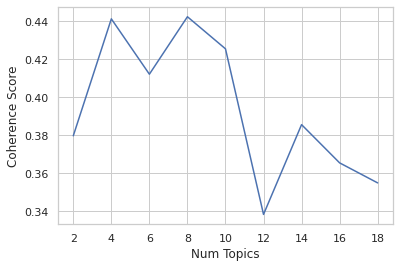

In [29]:
x = range(start, limit, step)
fig = plt.figure()
ax = plt.plot(x, coherence_list)
plt.xticks(x)
plt.xlabel("Num Topics")
plt.ylabel("Coherence Score") 
plt.show()

In [30]:
pickle.dump(model_list, open("../data/model_list.p", "wb"))
pickle.dump(coherence_list, open("../data/coherence_list.p", "wb"))

/home/donal/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


From the above graph we can judge the point of diminishing returns / accuracy loss for number of topics.

In [31]:
# index of max coherence
max_index = [i for i in range(len(coherence_list)) if max(coherence_list) == coherence_list[i]][0]
optimum_model = model_list[max_index]


/home/donal/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [46]:
pyLDAvis.enable_notebook(sort=True)
vis = pyLDAvis.gensim.prepare(optimum_model, corpus, dictionary, sort_topics=False)
pyLDAvis.display(vis)

/home/donal/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [36]:
%pprint

Pretty printing has been turned ON


/home/donal/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [40]:
optimum_model.print_topics()[1][1]

/home/donal/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


str

The topics shown in the plot are listed below.

The number before each entry is the weighting of the token within each topic.

In [45]:
for i, entry in enumerate(optimum_model.print_topics(), 1):
    topic = entry[1]
    print("Topic %d: %s" % (i, topic))

Topic 1: 0.024*"thank" + 0.017*"send" + 0.017*"need" + 0.013*"change" + 0.012*"information" + 0.011*"question" + 0.011*"follow" + 0.010*"message" + 0.010*"list" + 0.010*"agreement"
Topic 2: 0.122*"mail" + 0.051*"pmto" + 0.038*"response" + 0.027*"lose" + 0.025*"net" + 0.020*"student" + 0.020*"reply" + 0.017*"message" + 0.016*"cent" + 0.014*"hotmail"
Topic 3: 0.010*"free" + 0.009*"week" + 0.009*"br" + 0.008*"play" + 0.008*"game" + 0.008*"night" + 0.008*"weekend" + 0.008*"great" + 0.007*"friend" + 0.007*"ticket"
Topic 4: 0.284*"ect" + 0.039*"pm" + 0.035*"ectcc" + 0.028*"forward" + 0.022*"ee" + 0.015*"confirm" + 0.011*"enroncc" + 0.010*"credit" + 0.010*"intend" + 0.010*"reflect"
Topic 5: 0.037*"company" + 0.018*"business" + 0.017*"new" + 0.015*"trading" + 0.012*"service" + 0.011*"sell" + 0.011*"employee" + 0.010*"stock" + 0.009*"program" + 0.008*"share"
Topic 6: 0.044*"deal" + 0.029*"gas" + 0.027*"price" + 0.021*"day" + 0.020*"contract" + 0.016*"trade" + 0.016*"month" + 0.015*"image" + 0.0

/home/donal/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Results
Based on the results, eight topics best describes the data. 

Topics appear to be:
1. Looking for further information on something
2. 
3. Social events
4. 
5. stocks
6. gas 
7. 
8. energy 

the above is my best guess for some of the topics and would need to be looked into further to confirm.